<h1>Welcome to the Least Time Path Simulation!</h1>

<IPython.core.display.Javascript object>

y**(1/2), y**(2), y**(-1/2)
Match Found
Bounds: [ 1.0 , 2.56 ]
Match Found
Bounds: [ 1.0 , 1.265 ]
Match Found
Bounds: [ 0.391 , 1.0 ]


<IPython.core.display.Javascript object>

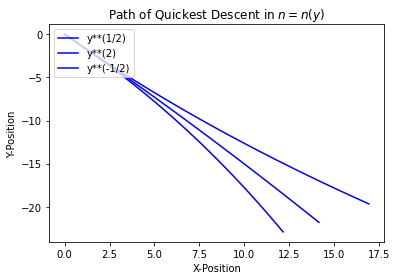

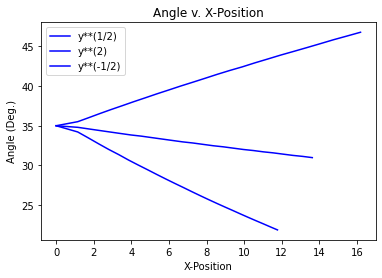

In [9]:
# INITIALIZATION 
from vpython import *
from scipy.optimize import fsolve
import math
import numpy as np
from sympy import Eq, Symbol, solve
import matplotlib.pyplot as plt
import ipywidgets as widgets

upbutton = widgets.Button(description = 'Try Different Paths')
downbutton = widgets.Button(description = 'Calculate Action')
out = widgets.Output()

scene = canvas(background = color.white)

y = Symbol('y')

i = input()
i = ''.join(i).split(',')

for x in range(0, len(i)):
    i[x] = i[x].strip()
    
userMediums = i

sizes = []

# DYNAMIC RANGE COMPRESSION
def refIndexSize(medium):
    if medium == "ceil(y)":
        print("Match Found")
        lowerBound = 9
        upperBound = 15
        print("Bounds: [",lowerBound, ",",upperBound,"]")
    elif "y" not in medium:
        print("Constant Function Not Accepted")
        i = input("n(y) = ")
        y = Symbol('y')
        medium = i
    else:
        print("Match Found")

        lowerProfile = Eq(eval(medium), 1)
        upperProfile = Eq(eval(medium), 1.6)
        bounds = [abs(round(float(solve(lowerProfile)[0]),3)),
                  abs(round(float(solve(upperProfile)[0]),3))]
        lowerBound = np.amin(bounds)
        upperBound = np.amax(bounds)

        print("Bounds: [",lowerBound, ",",upperBound,"]")
        
    def refractiveProfile(y):
        if medium == "ceil(y)":
            return math.ceil(y)/10
        elif "y" not in medium:
            return int(medium)
        else:
            return eval(medium, {'y': y, 'np': np})

    x = np.arange(lowerBound,upperBound-0.01, 0.01)
    refIndex = np.array([])
    
    for i in x:
        refIndex = np.append(refIndex, refractiveProfile(i))
   
    return len(refIndex)

for i in range(0, len(userMediums)):
    sizes.append(refIndexSize(userMediums[i]))

cutoff = np.min(sizes)

scene = canvas(background = color.white)

# REFRACTS A GIVEN VECTOR
def refract(userProfile, tint, opacity, shade, stop):
    def createRay(start, angle, size=2):
        v1 = vec(0,-1,0)
        return arrow(pos = start, axis = size * v1.rotate(radians(angle)),
                     shaftwidth = 0.2, headwidth = 0.3, headlength = 0.3, color = shade)
   
    def refractRay(refIndex1, refIndex2, vector_inc):
        v1 = vec(0,-1,0)
        theta_inc = diff_angle(v1,vector_inc.axis)
        theta_ref = asin((refIndex1/refIndex2) * sin(theta_inc))
        return arrow(pos = vector_inc.pos+vector_inc.axis, axis = v1.rotate(theta_ref),
                     shaftwidth = 0.2, headwidth = 0.3, headlength = 0.3, color = shade)
   
    if userProfile == "ceil(y)":
        lowerBound = 9
        upperBound = 15
    elif "y" not in userProfile:
        print("Constant Function Not Accepted")
        i = input("n(y) = ")
        y = Symbol('y')
        medium = i
    else:
        lowerProfile = Eq(eval(userProfile), 1)
        upperProfile = Eq(eval(userProfile), 1.6)
        bounds = [abs(round(float(solve(lowerProfile)[0]),3)),
                  abs(round(float(solve(upperProfile)[0]),3))]
        lowerBound = np.amin(bounds)
        upperBound = np.amax(bounds)

        
    def refractiveProfile(y):
        if userProfile == "ceil(y)":
            return math.ceil(y)/10
        elif "y" not in userProfile:
            return int(userProfile)
        else:
            return eval(userProfile, {'y': y, 'np': np})
 
    def d_fun(x):
            h = 1e-5
            return (refractiveProfile(x+h)-refractiveProfile(x-h))/(2*h)

    x = np.arange(lowerBound,upperBound-0.01, 0.01)        
    indicesOne = []
   
    change = d_fun(np.random.uniform(lowerBound,upperBound))
    tracker = []
   
    for i in x:
        indicesOne.append(refractiveProfile(i))
        tracker.append(i)
    if change < 0:
        indicesFinal = (np.round(np.sort(np.asarray(indicesOne)),3)[::-1])
    else:
        indicesFinal = (np.round(np.sort(np.asarray(indicesOne)),3))  
   
    light = createRay(vec(0,0,0), 35)
    v = [light]
    x_positions = np.array([light.pos.x])
    y_positions = np.array([light.pos.y])
    ver_V = [light.pos.y]
    angles = []

    for i in range (0, stop-1):
        newLight = refractRay(indicesFinal[i], indicesFinal[i+1], v[i])
        v.append(newLight)
        x_positions = np.append(x_positions, newLight.pos.x)
        y_positions = np.append(y_positions, newLight.pos.y)
        ver_V.append(newLight.pos.y+newLight.axis.y)
        angles.append(degrees(diff_angle(vec(0,-1,0), v[i].axis)))

    plt.figure(0)
    plt.plot(x_positions, y_positions, label=userProfile, color = tint, alpha = opacity)
    plt.legend(loc="upper left")
   
    plt.figure(1)
    plt.plot(x_positions[0:stop-1], angles[0:stop-1], label=userProfile, color = tint, alpha = opacity)
    plt.legend(loc="upper left")

    horSum = 0
    verSum = 0
    for i in range(0,len(v)):
        horSum += (v[i].pos.x+(v[i].axis.x)/2)
        verSum += (v[i].pos.y+(v[i].axis.y/2))
    horAvg = horSum / len(v)
    verAvg = verSum / len(v)
    hi = vec(horAvg,verAvg,0)
    scene.center = hi
    boxOfThings = [v[-1].pos+v[-1].axis, ver_V, v, indicesFinal]
    return boxOfThings

# ACTION FOR ALTERNATIVE PATHS
def alternativePaths(handMeDowns):

    drag = False
    endPoint = sphere(pos = savePos[0], radius = 0.1)
    standard = arrow(axis = vec(0,-1,0))
    standard.visible = False
    s = arrow(color=color.red, shaftwidth=0.1, axis = (0.5*mag(endPoint.pos)*standard.axis))
    k = arrow(color=color.orange, shaftwidth=0.1)
    difference = 0

    def down():
        global drag
        drag = True

    def move():
        global drag
        if drag:
            s.axis = 0.5*mag(endPoint.pos)*scene.mouse.pos.norm()
            k.pos = s.pos + s.axis
            k.axis = endPoint.pos - (s.pos + s.axis)

    def up():
        global drag
        drag = False

    scene.bind("mousedown", down)
    scene.bind("mousemove", move)
    scene.bind("mouseup", up)
    count = [0]
   
   
    def calcAction(inputMedium, vectors):
        vA = vectors[0]
        vB = vectors[1]
        ver_V = handMeDowns[0]
        v = handMeDowns[1]
        indicesFinal = handMeDowns[2]

        def find_nearest(array, value):    
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx

        verA = vA.pos.y+vA.axis.y
        boundA = find_nearest(ver_V,verA)

        verB = vB.pos.y+vB.axis.y
        boundB = find_nearest(ver_V,verB)

        totalTimeA = 0
        totalTimeB = 0
        for i in range(0, boundA):
            totalTimeA += (1 + ( mag(v[i].axis)-comp(v[i].axis, vA.axis) )) * ( mag(v[i].axis) * indicesFinal[i] )

        for i in range(boundA, boundB):
            totalTimeB += ( 1 + ( mag(v[i].axis)-comp(v[i].axis, vB.axis) ) ) * ( mag(v[i].axis) * indicesFinal[i] )

        
        return totalTimeA+totalTimeB

    def down_button_clicked(_, incr = 1): 
        with out:
            count[0] += incr
            y = np.zeros(1)
            fh, ax = plt.subplots(1,1)
            ax.scatter(calcAction(userMediums[0],[s,k]),y)
            ax.set_ylim(-1, 1)
            ax.set_xlim(0, 100)
            ax.axes.get_yaxis().set_visible(False)  
            ax.set_aspect(0.5, adjustable='box')  
            plt.title('Action for Path #'+str(count[0])+": "+str(round(calcAction(userMediums[0],[s,k]))))

    downbutton.on_click(down_button_clicked) 

# DRAWS PATH OF LEAST TIME USING FOR LOOP
def drawPath():
    savePos = []
    for i in range (0, len(userMediums)):
        whole = refract(userMediums[i], "blue", 1, vec(0,0,1), cutoff)
        a = whole[0]
        b = whole[1]
        c = whole[2]
        d = whole[3]
        savePos.append(a)
 
# GENERATE BUTTONS AND GRAPHS
def up_button_clicked(_): 
    with out:
        if len(userMediums) > 1:
            print("Alternative Paths Only if One Profile Entered")
        else:
            stuff=[b,c,d]
            alternativePaths(stuff)
       
def generateGraphs():
    plt.figure(0, figsize=(10, 6), dpi=200)
    plt.xlabel("X-Position")
    plt.ylabel("Y-Position")
    plt.title("Path of Quickest Descent in $n=n(y)$")
    y = Symbol('y')

    plt.figure(1, figsize=(10, 6), dpi=200)
    plt.xlabel("X-Position")
    plt.ylabel("Angle (Deg.)")
    plt.title("Angle v. X-Position")

# RUN ALL FUNCTIONS
upbutton.on_click(up_button_clicked) 
drawPath()
generateGraphs()
buttons = widgets.HBox([upbutton, downbutton]) 
widgets.VBox([buttons, out])

<h3><mark style = "background: #ed462f; color: white;">Please wait. The simulation is loading.</mark> </h3>
    
Type a function of $y$ like `y**(-1/2)` for a Brachistochrone or `ceil(y)` for a step function. Enjoy!